In [1]:
%load_ext autoreload

In [40]:
%autoreload
from ceruleanml.multispectral_blocks import open_n_channel_img, open_mask_from_record, MSTensorImage, MSTensorMask
from fastai.data.block import TransformBlock
from functools import partial
from fastai.vision.core import AddMaskCodes
from ceruleanml import data
from ceruleanml import evaluation
from ceruleanml import preprocess
from fastai.data.block import DataBlock
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.augment import aug_transforms, Resize
from fastai.vision.learner import unet_learner
from fastai.data.transforms import IndexSplitter, Normalize
from fastai.metrics import DiceMulti, Dice
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from torchvision.models import resnet18, resnet34, resnet50
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.tensorboard import TensorBoardCallback
from datetime import datetime
from pathlib import Path
import os, random
from icevision.visualize import show_data
import torch
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback
from fastai.vision.core import PILImageBW
from fastai.losses import DiceLoss


### Parsing COCO Dataset with Icevision

In [3]:
with_context=False
mount_path = "/root/"
train_set = "train-no-context-512"
tiled_images_folder_train = "tiled_images_no_context"
json_name_train = "instances_TiledCeruleanDatasetV2NoContextFiles.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-no-context-512"
tiled_images_folder_val= "tiled_images_no_context"
json_name_val = "instances_TiledCeruleanDatasetV2NoContextFiles.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

#with aux files
# with_context=True
# mount_path = "/root/"
# train_set = "train-with-context-512"
# tiled_images_folder_train = "tiled_images"
# json_name_train = "instances_TiledCeruleanDatasetV2.json"

# coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
# tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
# val_set = "val-with-context-512"
# tiled_images_folder_val= "tiled_images"
# json_name_val = "instances_TiledCeruleanDatasetV2.json"
# coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
# tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 10
# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

In [4]:
# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df.groupby("label").count()

In [5]:
record_collection_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=True
)
record_ids_train = record_collection_to_record_ids(record_collection_train)

  0%|          | 0/3863 [00:00<?, ?it/s]

100%|██████████| 3014/3014 [00:00<00:00, 115675.82it/s]


0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


0it [00:00, ?it/s]

In [6]:
record_collection_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=True
)
record_ids_val = record_collection_to_record_ids(record_collection_val)

  0%|          | 0/352 [00:00<?, ?it/s]

100%|██████████| 266/266 [00:00<00:00, 108088.05it/s]


0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


0it [00:00, ?it/s]

In [7]:
assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

In [8]:
train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_train + record_collection_val

def get_val_indices(combined_ids, val_ids):
    return list(range(len(combined_ids)))[-len(val_ids):]

val_indices = get_val_indices(train_val_record_ids, record_ids_val)

In [9]:
#show_data.show_records(random.choices(combined_train_records, k=9), ncols=3)

### Constructing a FastAI DataBlock that uses parsed COCO Dataset from icevision parser and applies transformations

In [10]:
size = 128  # Progressive resizing could happen here
def get_image_by_record_id(record_id):
    return get_image_path(combined_record_collection, record_id)

def get_mask_by_record_id(record_id):
    return record_to_mask(combined_record_collection, record_id)

def create_data_block(size, with_context=True):
    imblock = ImageBlock if with_context else ImageBlock(cls=PILImageBW)
        
    coco_seg_dblock = DataBlock(
            blocks=(imblock, MaskBlock(codes=class_ints)), # ImageBlock is RGB by default, uses PIL
            get_x=get_image_by_record_id,
            splitter=IndexSplitter(val_indices),
            get_y=get_mask_by_record_id,# *aug_transforms(),  # we need to normalize here or else fastai incorrectly normalizes by the pretrained stats
            item_tfms=Resize(size),
            n_inp=1
        )
    return coco_seg_dblock
coco_seg_dblock = create_data_block(size, with_context=with_context)
dls = coco_seg_dblock.dataloaders(source=train_val_record_ids, batch_size=6)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [20]:
db_custom = DataBlock(blocks=(TransformBlock(type_tfms=partial(MSTensorImage.create, chnls=[0], record_collection=combined_record_collection)),
                       TransformBlock(type_tfms=partial(MSTensorMask.create, record_collection=combined_record_collection), 
                                      item_tfms=AddMaskCodes(codes=class_ints)),
                      ),
               get_items=record_collection_to_record_ids,
               splitter=IndexSplitter(val_indices),
               n_inp=1,
               item_tfms=Resize(size)
              )

dls_custom = db_custom.dataloaders(source=combined_record_collection, bs=6)

## Inspecting why Fastai DataBlock converts single channel to 3 channel

In [21]:
original_x,original_y = dls.one_batch()

In [22]:
custom_x, custom_y = dls_custom.one_batch()

In [23]:
print(original_x.shape,original_y.shape)

torch.Size([6, 1, 128, 128]) torch.Size([6, 128, 128])


In [24]:
print(custom_x.shape,custom_y.shape)

torch.Size([6, 1, 512, 512]) torch.Size([6, 512, 512])


In [13]:
MSTensorImage.create(94, chnls=[0], record_collection=combined_record_collection)

MSTensorImage: torch.Size([1, 512, 512])

In [30]:
coco_seg_dblock.summary(source=train_val_record_ids)

Setting-up type transforms pipelines
Found 3280 items
2 datasets of sizes 3014,266
Setting up Pipeline: get_image_by_record_id -> PILBase.create
Setting up Pipeline: get_mask_by_record_id -> PILBase.create

Building one sample
  Pipeline: get_image_by_record_id -> PILBase.create
    starting from
      94
    applying get_image_by_record_id gives
      /root/partitions/train-no-context-512/tiled_images_no_context/S1A_IW_GRDH_1SDV_20200729T034859_20200729T034924_033664_03E6D3_93EF_vv-image_local_tile_94.tif
    applying PILBase.create gives
      PILImageBW mode=L size=512x512
  Pipeline: get_mask_by_record_id -> PILBase.create
    starting from
      94
    applying get_mask_by_record_id gives
      [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
    applying PILBase.create gives
      PILMask mode=L size=512x512

Final sample: (PILImageBW mode=L size=512x512, PILMask mode=L size=512x512)


Found 3280 items
2 datas

In [32]:
aug_transforms??

Signature:
aug_transforms(
    mult=1.0,
    do_flip=True,
    flip_vert=False,
    max_rotate=10.0,
    min_zoom=1.0,
    max_zoom=1.1,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75,
    xtra_tfms=None,
    size=None,
    mode='bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Source:   
def aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10., min_zoom=1., max_zoom=1.1,
                   max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None,
                   mode='bilinear', pad_mode=PadMode.Reflection, align_corners=True, batch=False, min_scale=1.):
    "Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms."
    res,tkw = [],dict(size=size if min_scale==1. else None, mode=mode, pad_mode=pad_mode, batch=batch, align_corners=align_corners)
    max_rotate,max_lighting,max_warp = array([max_rotate,max_lighting,max_wa

In [31]:
Resize??

Init signature:
Resize(
    self,
    size,
    method='crop',
    pad_mode='reflection',
    resamples=(2, 0),
    **kwargs,
)
Docstring:      A transform that before_call its state at each `__call__`
Source:        
@delegates()
class Resize(RandTransform):
    split_idx,mode,mode_mask,order = None,Image.BILINEAR,Image.NEAREST,1
    "Resize image to `size` using `method`"
    def __init__(self, size, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection,
                 resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        size = _process_sz(size)
        store_attr()
        super().__init__(**kwargs)
        self.mode,self.mode_mask = resamples

    def before_call(self, b, split_idx):
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5) if split_idx else (random.random(),random.random())

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        orig_sz = _get_sz(x)
        if self.method==ResizeMethod.Squish:
            return x

# original transforms
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
    starting from
      (PILImageBW mode=L size=512x512, PILMask mode=L size=512x512)
    applying AddMaskCodes gives
      (PILImageBW mode=L size=512x512, PILMask mode=L size=512x512)
    applying Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} gives
      (PILImageBW mode=L size=128x128, PILMask mode=L size=128x128)
    applying ToTensor gives
      (TensorImageBW of size 1x128x128, TensorMask of size 128x128)

# custom transforms
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
    starting from
      (MSTensorImage of size 1x512x512, MSTensorMask of size 512x512)
    applying AddMaskCodes gives
      (MSTensorImage of size 1x512x512, MSTensorMask of size 512x512)
    applying Resize -- {'size': (128, 128), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} gives
      (MSTensorImage of size 1x512x512, MSTensorMask of size 512x512)
    applying ToTensor gives
      (MSTensorImage of size 1x512x512, MSTensorMask of size 512x512)

In [26]:
db_custom.summary(source=combined_record_collection)

Setting-up type transforms pipelines
Found 3280 items
2 datasets of sizes 3014,266
Setting up Pipeline: partial
Setting up Pipeline: partial

Building one sample
  Pipeline: partial
    starting from
      94
    applying partial gives
      MSTensorImage of size 1x512x512
  Pipeline: partial
    starting from
      94
    applying partial gives
      MSTensorMask of size 512x512

Final sample: (MSTensorImage([[[49., 56., 57.,  ..., 49., 52., 53.],
         [60., 64., 58.,  ..., 50., 49., 44.],
         [59., 54., 56.,  ..., 53., 45., 36.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]), MSTensorMask([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]))


Found 3280 items
2 datasets of s

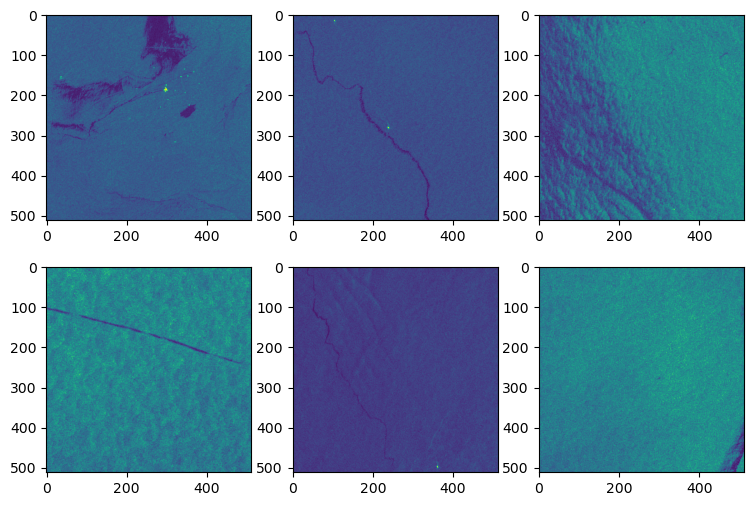

In [20]:
dls_custom.show_batch(b=b,chnls=[0], show_label=False)

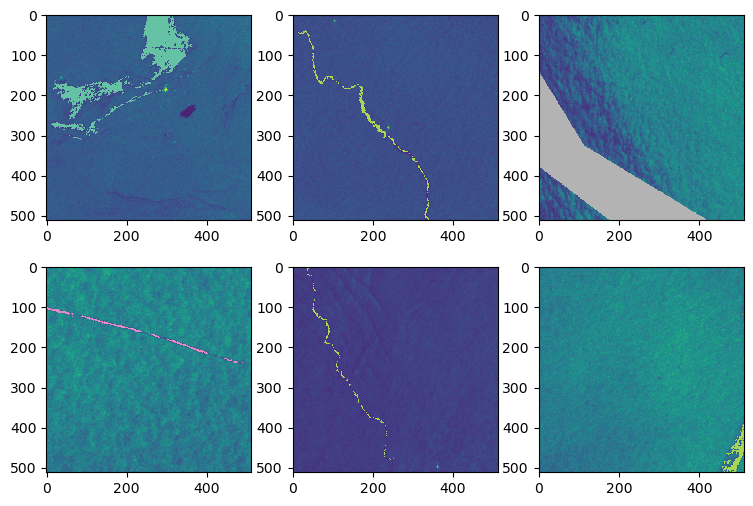

In [21]:
dls_custom.show_batch(b=b,chnls=[0], show_label=True)

In [34]:
import numpy as np
for i in range(b[1].shape[0]):
    print(np.unique(b[1][i].cpu().detach().numpy()))

NameError: name 'b' is not defined

https://docs.fast.ai/tutorial.siamese.html

https://towardsdatascience.com/how-to-create-a-datablock-for-multispectral-satellite-image-segmentation-with-the-fastai-v2-bc5e82f4eb5

### Fastai2 Trainer

In [47]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_fastai_unet/')
experiment_dir.mkdir(exist_ok=True)
print(experiment_dir)

arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

# removed these callbacks since they cause this error: https://forums.fast.ai/t/learner-object-has-no-attribute-recorder/46328/18
# or no model.pth found in experiment folder for some reason 
cbs = [#SaveModelCallback(monitor="valid_loss", with_opt=True), 
        # EarlyStoppingCallback(monitor='valid_loss', min_delta=0.005, patience=5), 
        #TensorBoardCallback(projector=False, trace_model=False)
]

/root/experiments/cv2/08_Jun_2022_00_13_55_fastai_unet


### mixing dice and focal loss
https://www.kaggle.com/code/iafoss/unet34-dice-0-87/notebook

In [22]:
from torch import nn
def dice_loss(inp, target):
    inp = torch.sigmoid(inp)
    smooth = 1.0

    iflat = inp.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, inp, target):
        if not (target.size() == inp.size()):
            raise ValueError("Target size ({}) must be the same as inp size ({})"
                             .format(target.size(), inp.size()))

        max_val = (-inp).clamp(min=0)
        loss = inp - inp * target + max_val + \
            ((-max_val).exp() + (-inp - max_val).exp()).log()

        invprobs = F.logsigmoid(-inp * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, inp, target):
        loss = self.alpha*self.focal(inp, target) - torch.log(dice_loss(inp, target))
        return loss.mean()

In [23]:
from fastai.losses import DiceLoss

In [36]:
db_custom = DataBlock(blocks=(TransformBlock(type_tfms=partial(MSTensorImage.create, chnls=[0], record_collection=combined_record_collection)),
                       TransformBlock(type_tfms=partial(MSTensorMask.create, record_collection=combined_record_collection), 
                                      item_tfms=AddMaskCodes(codes=class_ints)),
                      ),
               get_items=record_collection_to_record_ids,
               splitter=IndexSplitter(val_indices),
               n_inp=1,
               item_tfms=Resize(size)
              )

dls_custom = db_custom.dataloaders(source=combined_record_collection, bs=6)

In [45]:
dls_custom.one_batch()[0].shape

torch.Size([6, 3, 512, 512])

In [38]:
with_context

False

In [48]:
# learner.recorder.metric_names
def create_learner(dls,with_context=True):
    if with_context:
        learner = unet_learner(dls, archs[arch], metrics=[DiceMulti()], 
                               model_dir=experiment_dir, n_in=3, n_out = 7, 
                               cbs=cbs, loss_func=DiceLoss()) #cbs=cbs# SaveModelCallback saves model when there is improvement
    else:
        learner = unet_learner(dls, archs[arch], metrics=[DiceMulti()], 
                               model_dir=experiment_dir, n_in=1, n_out = 7, 
                               cbs=cbs, loss_func=DiceLoss()) #cbs=cbs# SaveModelCallback saves model when there is improvement
    return learner
learner = create_learner(dls_custom, with_context=with_context)
# lr = learner.lr_find()

In [50]:
dls_custom.one_batch()[0].shape

torch.Size([6, 3, 512, 512])

In [51]:
unet_learner??

Signature:
unet_learner(
    dls,
    arch,
    normalize=True,
    n_out=None,
    pretrained=True,
    config=None,
    loss_func=None,
    opt_func=<function Adam at 0x7fd67da22430>,
    lr=0.001,
    splitter=None,
    cbs=None,
    metrics=None,
    path=None,
    model_dir='models',
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    cut=None,
    n_in=3,
    blur=False,
    blur_final=True,
    self_attention=False,
    y_range=None,
    last_cross=True,
    bottle=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    init=<function kaiming_normal_ at 0x7fd6afa58f70>,
    norm_type=None,
)
Source:   
@delegates(create_unet_model)
def unet_learner(dls, arch, normalize=True, n_out=None, pretrained=True, config=None,
                 # learner args
                 loss_func=None, opt_func=Adam, lr=defaults.lr, splitter=None, cbs=None, metrics=None, path=None,
                 model_dir='models', wd=None, wd_bn_bias=False, train_bn=Tr

In [54]:
from fastai.vision.learner import create_unet_model

In [57]:
from fastai.vision.models.unet import DynamicUnet

In [58]:
DynamicUnet??

Init signature:
DynamicUnet(
    encoder,
    n_out,
    img_size,
    blur=False,
    blur_final=True,
    self_attention=False,
    y_range=None,
    last_cross=True,
    bottle=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    init=<function kaiming_normal_ at 0x7fd6afa58f70>,
    norm_type=None,
    **kwargs,
)
Source:        
class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_out, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
      

In [55]:
create_unet_model??

Signature:
create_unet_model(
    arch,
    n_out,
    img_size,
    pretrained=True,
    cut=None,
    n_in=3,
    blur=False,
    blur_final=True,
    self_attention=False,
    y_range=None,
    last_cross=True,
    bottle=False,
    act_cls=<class 'torch.nn.modules.activation.ReLU'>,
    init=<function kaiming_normal_ at 0x7fd6afa58f70>,
    norm_type=None,
)
Source:   
@delegates(models.unet.DynamicUnet.__init__)
def create_unet_model(arch, n_out, img_size, pretrained=True, cut=None, n_in=3, **kwargs):
    "Create custom unet architecture"
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, n_in, pretrained, ifnone(cut, meta['cut']))
    model = models.unet.DynamicUnet(body, n_out, img_size, **kwargs)
    return model
File:      ~/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/vision/learner.py
Type:      function


In [49]:
learner.summary()

RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[1, 3, 512, 512] to have 1 channels, but got 3 channels instead

In [32]:
learner = unet_learner(dls_custom, archs[arch], metrics=[DiceMulti()], 
                       model_dir=experiment_dir, n_in=1, n_out = 7, 
                       cbs=cbs, loss_func=DiceLoss()) #cbs=cbs# SaveModelCallback saves model when there is improvement

dice_multi changes a little bit when training with fewer samples. but not with more samples???

In [19]:
dls_custom.one_batch()

(MSTensorImage: torch.Size([6, 1, 512, 512]),
 MSTensorImage: torch.Size([6, 512, 512]))

In [44]:
learner.fine_tune(1, 1e-4, freeze_epochs=1) # cbs=cbs

epoch,train_loss,valid_loss,dice_multi,time


RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[6, 3, 512, 512] to have 1 channels, but got 3 channels instead

In [34]:
!tensorboard --logdir="./runs"

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [24]:
# validation = learner.validate()  
# there's a strange bug here where an internal method is not found that should be found 
# for the Callback class. seems like a verison mismatch issue. happens if any callback included

In [26]:
size=512
# savename = f'test_6batch_{arch}_{size}_{round(validation[1],3)}.pt'
savename = f'test_6batch_{arch}_{size}.pt'

We save the best model in a variety of formats for loading later

In [26]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes

state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, savename, experiment_dir)

../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/tracing_gpu_test_6batch_18_512.pt
../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/tracing_cpu_test_6batch_18_512.pt
../../experiments/cv2/01_Jun_2022_02_12_35_fastai_unet/state_dict_test_6batch_18_512.pt


In [29]:
#import pdb
#learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)


# Model Inference and Result Evaluation

import skimage.io as skio
import numpy as np
val_record_ids = record_collection_to_record_ids(record_collection_val)
pred_arrs = []
val_arrs = []
for v, i in zip(range(len(record_ids_val[0:10])), record_ids_val[0:10]):
    v = record_collection_val[v]
    v_masks = v.detection.masks[0].to_mask(v.common.height,v.common.width).data
    p = get_image_path(record_collection_val,i)
    arr = skio.imread(p)
    # necessary for 1 channel input since fastai uses PIL during predict
    class_pred = learner.predict(np.squeeze(arr))
    class_pred = class_pred[0].cpu().detach().numpy()
    pred_arrs.append(class_pred)
    val_arrs.append(v_masks)

/root/miniconda3/envs/fastai2/lib/python3.9/site-packages/fastai/metrics.py:370: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


In [31]:
data.class_mapping_coco

{'Infrastructure': 1,
 'Natural Seep': 2,
 'Coincident Vessel': 3,
 'Recent Vessel': 4,
 'Old Vessel': 5,
 'Ambiguous': 6,
 'Hard Negatives': 0}

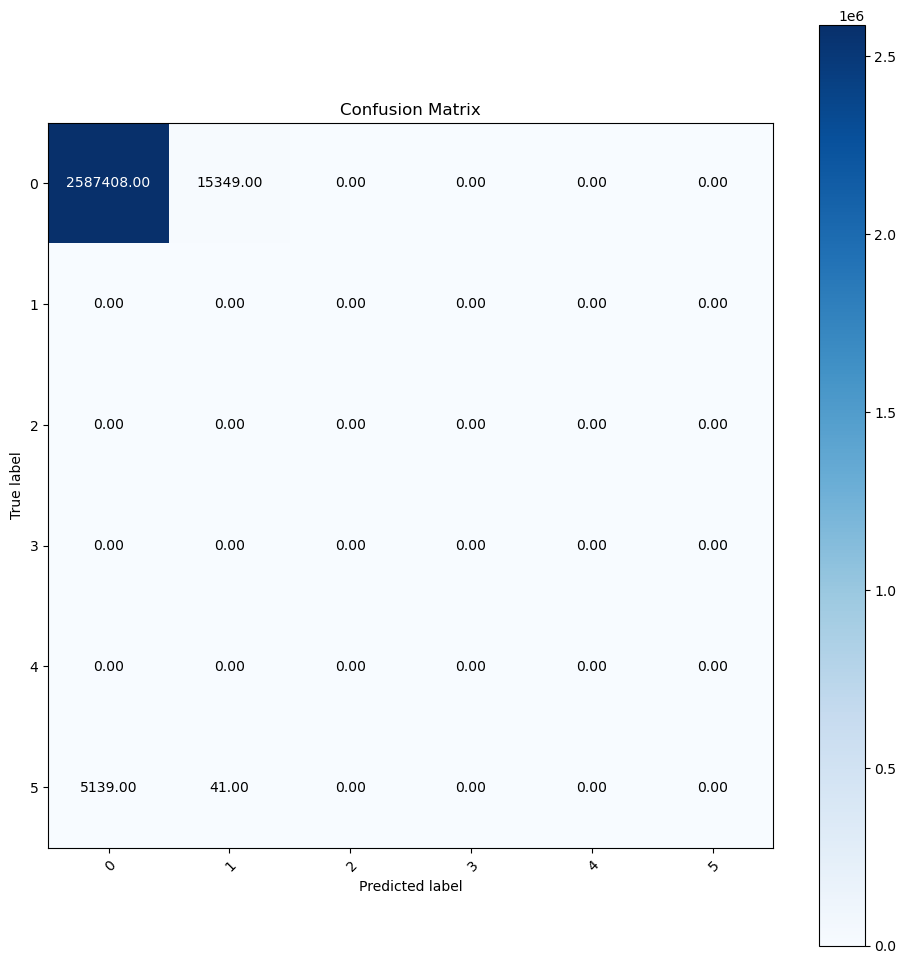

In [30]:
cm, f1 = evaluation.cm_f1(val_arrs, pred_arrs, 6, mount_path)

In [ ]:
learner = torch.load("/root/data/experiments/cv2/10_May_2022_18_02_59_fastai_unet/18_64_0.493.pkl")


import skimage.io as skio
val_record_ids = record_collection_to_record_ids(valid_records)
pred_arrs = []
with learner.no_logging():
    for i in val_record_ids:
        p = get_image_path(valid_records,i)
        arr = skio.imread(p)
        pred_arr = learner.predict(arr)
        pred_arrs.append(pred_arr)

In [ ]:
# this results in vm dying, not just kernel crash
# coco_seg_dblock = DataBlock(
#     blocks=(ImageBlock, MaskBlock(codes=class_ints)),
#     get_x=get_image_by_record_id,
#     get_y=get_mask_by_record_id,
#     n_inp=1,
# )

# dls = coco_seg_dblock.dataloaders(source=record_ids, batch_size=5)


In [ ]:
result = learner.get_preds(dl=dls[0])

In [ ]:
learner.get_preds??

In [ ]:
len(pred_arrs)

In [ ]:
target_label,prediction_arr, activations = pred_arrs[0]

In [ ]:
skio.imshow(target_label.cpu().detach().numpy())

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[0])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy()[1])

In [ ]:
skio.imshow(base_img.cpu().detach().numpy())

In [ ]:
array([      60.73,       190.3,      4.3598]) # means
array([     16.099,      17.846,       9.603]) # stats